In [16]:
pip install pmdarima


   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   --------------------------------- ------ 524.3/625.1 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.7 MB 2.8 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.7 MB 2.3 MB/s eta 0:00:01
   ------------------------------- -------- 2.1/2.7 MB 2.9 MB/s eta 0:00:01
   -------------------------------------- - 2.6/2.7 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
 
from sklearn.metrics import mean_squared_error
from prophet import Prophet


In [51]:
df = pd.read_csv('retailstore_inventory.csv', parse_dates=['Date'], index_col='Date')

In [52]:
df.head()

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
Date,,,,,,,,,,,,,,
01-01-2022,S001,P0001,Groceries,North,231.0,127.0,55.0,135.47,33.50,20.0,Rainy,0.0,29.69,Autumn
01-01-2022,S001,P0002,Toys,South,204.0,150.0,66.0,144.04,63.01,20.0,Sunny,0.0,66.16,Autumn
01-01-2022,S001,P0003,Toys,West,102.0,65.0,51.0,74.02,27.99,10.0,Sunny,1.0,31.32,Summer
01-01-2022,S001,P0004,Toys,North,469.0,61.0,164.0,62.18,32.72,10.0,Cloudy,1.0,34.74,Autumn
01-01-2022,S001,P0005,Electronics,East,166.0,14.0,135.0,9.26,73.64,0.0,Sunny,0.0,68.95,Summer


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73100 entries, 01-01-2022 to nan
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store ID            73000 non-null  object 
 1   Product ID          73000 non-null  object 
 2   Category            73000 non-null  object 
 3   Region              73000 non-null  object 
 4   Inventory Level     73000 non-null  float64
 5   Units Sold          73000 non-null  float64
 6   Units Ordered       73000 non-null  float64
 7   Demand Forecast     73000 non-null  float64
 8   Price               73000 non-null  float64
 9   Discount            73000 non-null  float64
 10  Weather Condition   73000 non-null  object 
 11  Holiday/Promotion   73000 non-null  float64
 12  Competitor Pricing  73000 non-null  float64
 13  Seasonality         73000 non-null  object 
dtypes: float64(8), object(6)
memory usage: 8.4+ MB


In [54]:
df.isnull().sum()

Store ID              100
Product ID            100
Category              100
Region                100
Inventory Level       100
Units Sold            100
Units Ordered         100
Demand Forecast       100
Price                 100
Discount              100
Weather Condition     100
Holiday/Promotion     100
Competitor Pricing    100
Seasonality           100
dtype: int64

In [55]:
df.dtypes

Store ID               object
Product ID             object
Category               object
Region                 object
Inventory Level       float64
Units Sold            float64
Units Ordered         float64
Demand Forecast       float64
Price                 float64
Discount              float64
Weather Condition      object
Holiday/Promotion     float64
Competitor Pricing    float64
Seasonality            object
dtype: object

In [56]:
df.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000,73000.000000
mean,274.483178,136.470384,110.001274,141.500569,55.137655,10.009863,0.497342,55.148507
std,129.948423,108.919685,52.277153,109.256018,26.023478,7.083304,0.499996,26.192995
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.690000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.020000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.065000,77.870000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


<Figure size 800x500 with 0 Axes>

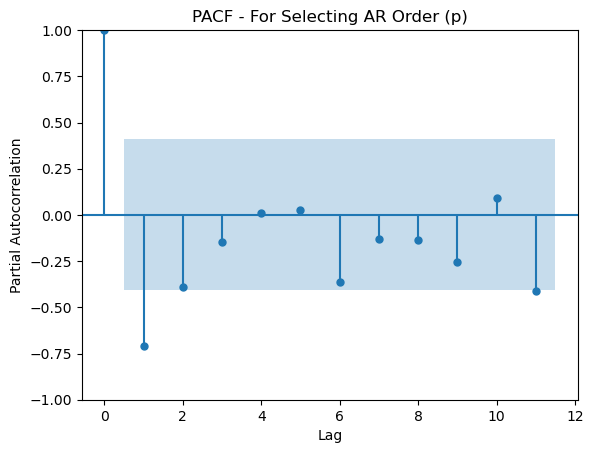

In [60]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Convert index to DatetimeIndex
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')

# Resample 'Units Sold' to monthly frequency and sum
monthly_sales = df['Units Sold'].resample('MS').sum()

# Compute differenced series and drop NaN
diff_series = monthly_sales.diff().dropna()

# Calculate max lags for PACF
max_lags = len(diff_series) // 2

# Plot PACF
plt.figure(figsize=(8, 5))
plot_pacf(diff_series, lags=max_lags, method='ywm')
plt.title('PACF - For Selecting AR Order (p)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

C:\Users\Madhura\AppData\Local\Temp\ipykernel_19356\3219324854.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df['Units Sold'].resample('M').mean()


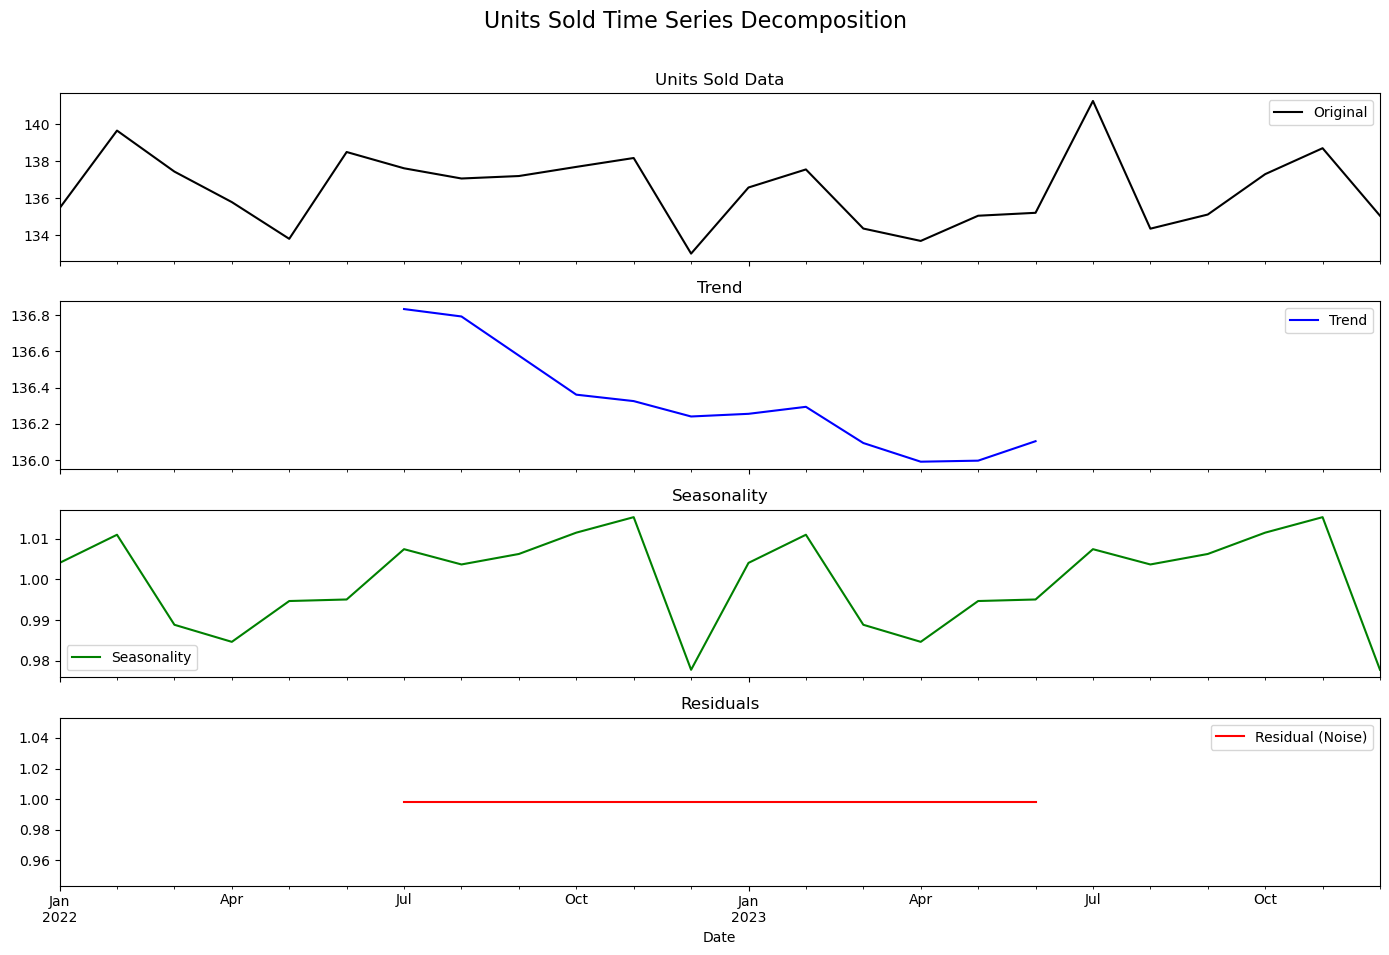

In [61]:

from statsmodels.tsa.seasonal import seasonal_decompose

df_monthly = df['Units Sold'].resample('M').mean() 

# Decompose monthly data with 12-month period 
result = seasonal_decompose(df_monthly, model='multiplicative', period=12)

# Plot  components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

df_monthly.plot(ax=ax1, color='black', label='Original')
ax1.set_title('Units Sold Data')
ax1.legend()

result.trend.plot(ax=ax2, color='blue', label='Trend')
ax2.set_title('Trend')
ax2.legend()

result.seasonal.plot(ax=ax3, color='green', label='Seasonality')
ax3.set_title('Seasonality')
ax3.legend()

result.resid.plot(ax=ax4, color='red', label='Residual (Noise)')
ax4.set_title('Residuals')
ax4.legend()

plt.suptitle("Units Sold Time Series Decomposition", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


C:\Users\Madhura\AppData\Local\Temp\ipykernel_19356\394496999.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Units Sold'].resample('M').sum()


<Figure size 800x500 with 0 Axes>

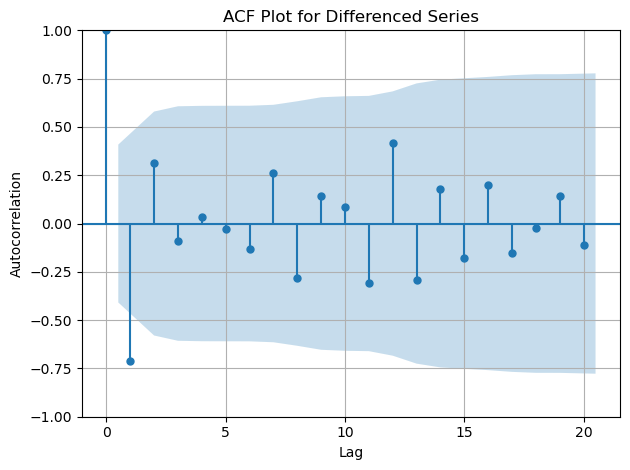

In [62]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Resample to monthly 
monthly_sales = df['Units Sold'].resample('M').sum()

# making it stationary
diff_series = monthly_sales.diff().dropna()

#  Ploting ACF to determine q
plt.figure(figsize=(8, 5))
plot_acf(diff_series, lags=20)
plt.title('ACF Plot for Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()


In [63]:
from statsmodels.tsa.stattools import adfuller

# monthly series
monthly_sales = df['Units Sold'].resample('M').sum()

# ADF test
result = adfuller(monthly_sales.dropna())

# Extract results
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation
if result[1] > 0.05:
    print("Data is non-stationary — use d = 1")
else:
    print("Data is stationary — use d = 0")


C:\Users\Madhura\AppData\Local\Temp\ipykernel_19356\2602779483.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Units Sold'].resample('M').sum()


ADF Statistic: -6.670844139972641
p-value: 4.592142540305684e-09
Data is stationary — use d = 0


C:\Users\Madhura\AppData\Local\Temp\ipykernel_19356\2570323126.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Units Sold'].resample('M').sum()
C:\Users\Madhura\AppData\Local\Temp\ipykernel_19356\2570323126.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_exog = exog.resample('M').sum()
C:\Users\Madhura\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Madhura\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Madhura\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameter

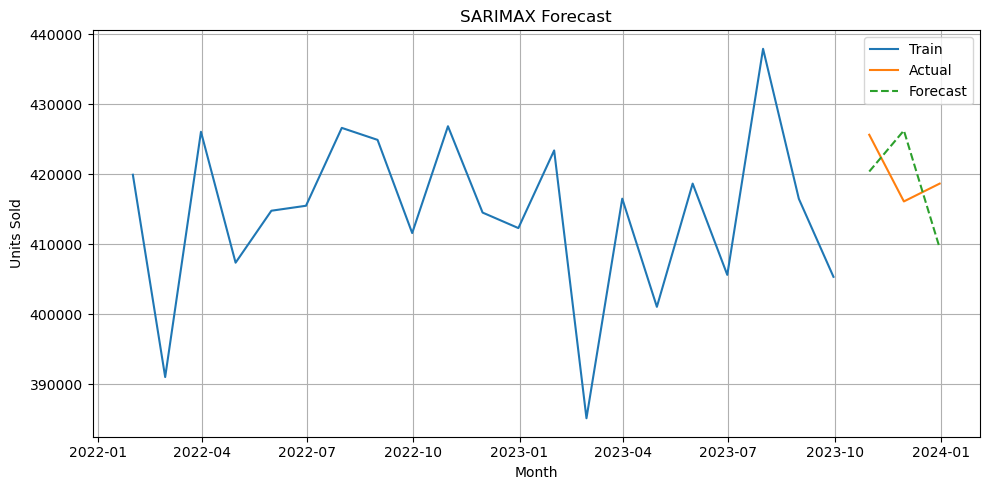

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt

# One-hot encode season column
season_dummies = pd.get_dummies(df['Seasonality'])

# Combine exogenous variables
exog = pd.concat([df['Holiday/Promotion'], season_dummies], axis=1)

# Resample monthly
monthly_sales = df['Units Sold'].resample('M').sum()
monthly_exog = exog.resample('M').sum()

# Train-test split
train = monthly_sales[:-3]
test = monthly_sales[-3:]
exog_train = monthly_exog[:-3]
exog_test = monthly_exog[-3:]

# Fit SARIMAX
model = SARIMAX(train, order=(2,0,2), seasonal_order=(1,1,1,12), exog=exog_train)
model_fit = model.fit()

# Forecast
s_forecast = model_fit.forecast(steps=3, exog=exog_test)

# Evaluate
#mae = mean_absolute_error(test, s_forecast)
#rmse = np.sqrt(mean_squared_error(test, s_forecast))
#print("SARIMAX MAE:", mae)
#print("SARIMAX RMSE:", rmse)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(s_forecast, label='Forecast', linestyle='--')
plt.title('SARIMAX Forecast')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Madhura\AppData\Local\Temp\ipykernel_19356\2325143840.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Units Sold'].resample('M').sum().reset_index()
15:35:27 - cmdstanpy - INFO - Chain [1] start processing
15:35:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Madhura\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


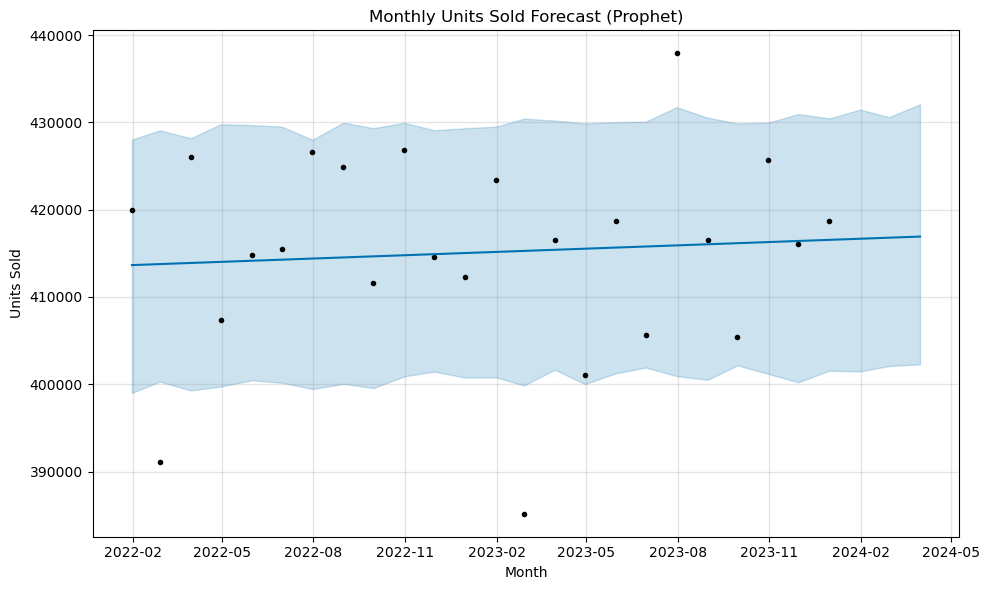

In [67]:
###Prophet
monthly_sales = df['Units Sold'].resample('M').sum().reset_index()
data = monthly_sales.rename(columns={'Date': 'ds', 'Units Sold': 'y'})

p_model = Prophet()
p_model.fit(data)

future = p_model.make_future_dataframe(periods=3, freq='M')

p_forecast = p_model.predict(future)


p_model.plot(p_forecast)
plt.title('Monthly Units Sold Forecast (Prophet)')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.tight_layout()
plt.show()

C:\Users\Madhura\AppData\Local\Temp\ipykernel_19356\2811248363.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Units Sold'].resample('M').sum()
C:\Users\Madhura\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Madhura\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


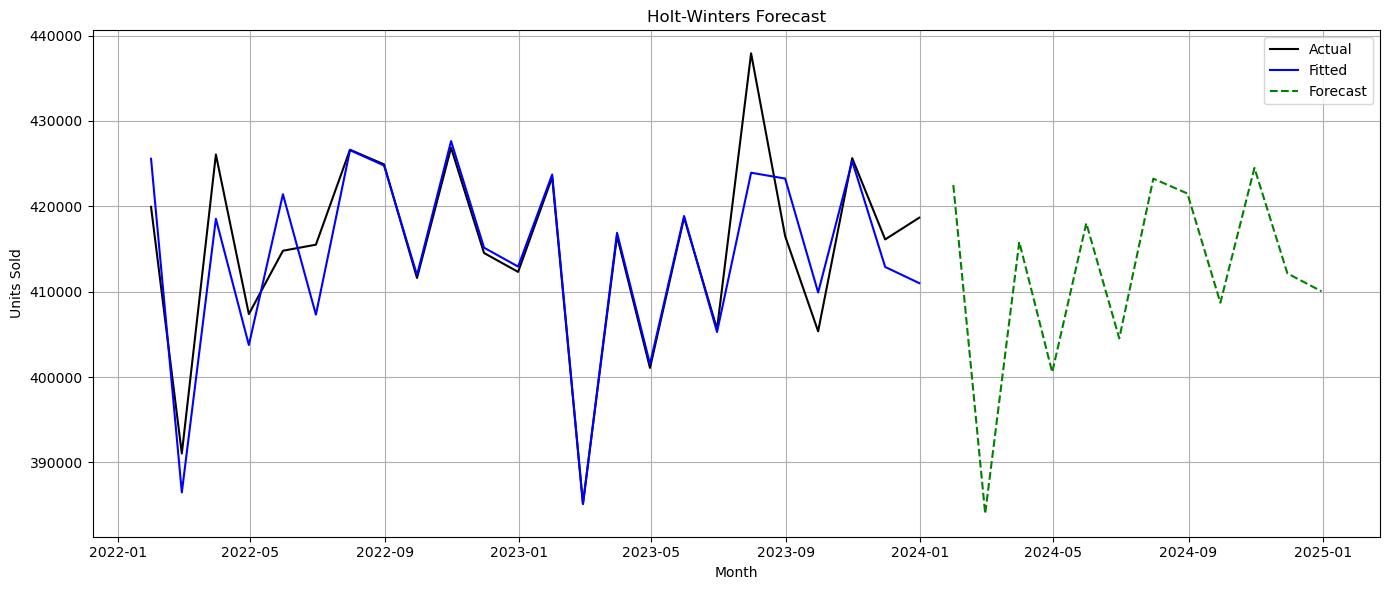

In [68]:
##holt winters
monthly_sales = df['Units Sold'].resample('M').sum()

#Holt-Winters model 
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12).fit()

# Forecast next 12 months
hw_forecast = model.forecast(12)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(monthly_sales, label='Actual', color='black')
plt.plot(model.fittedvalues, label='Fitted', color='blue')
plt.plot(hw_forecast, label='Forecast', color='green', linestyle='--')
plt.title('Holt-Winters Forecast')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


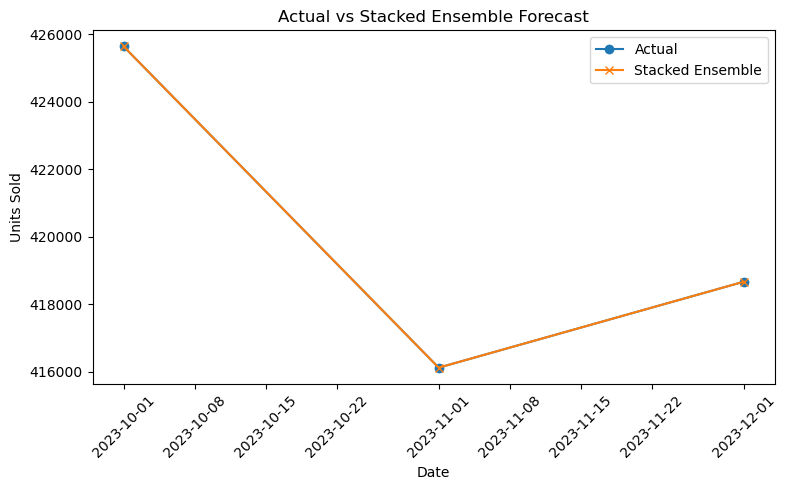

Model Weights (from Linear Regression):
Holt-Winters: 0.000
SARIMA:       0.500
Prophet:      0.500
Intercept:    0.00


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load and prepare data
df = pd.read_csv('retailstore_inventory.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
monthly_sales = df['Units Sold'].resample('MS').sum()
test_data = monthly_sales[-3:].to_frame(name='y')

# Placeholder forecasts (replace with real model outputs if available)
hw = test_data['y'] * 1.1  # Holt-Winters forecast
s = test_data['y'] * 1.05  # SARIMA forecast
p = test_data['y'] * 0.95  # Prophet forecast

# Create stacked dataset
X = np.column_stack([hw.values, s.values, p.values])  # Features
y = test_data['y'].values  # Actual values (target)

# Fit meta-model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(X, y)

# Stacked Ensemble Forecast
stacked_pred = meta_model.predict(X)

# Convert to Series for plotting
stacked_series = pd.Series(stacked_pred, index=test_data.index)

# Plot Actual vs Stacked Ensemble
plt.figure(figsize=(8, 5))
plt.plot(test_data.index, test_data['y'], 'o-', label='Actual')
plt.plot(stacked_series.index, stacked_series, 'x-', label='Stacked Ensemble')
plt.title('Actual vs Stacked Ensemble Forecast')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



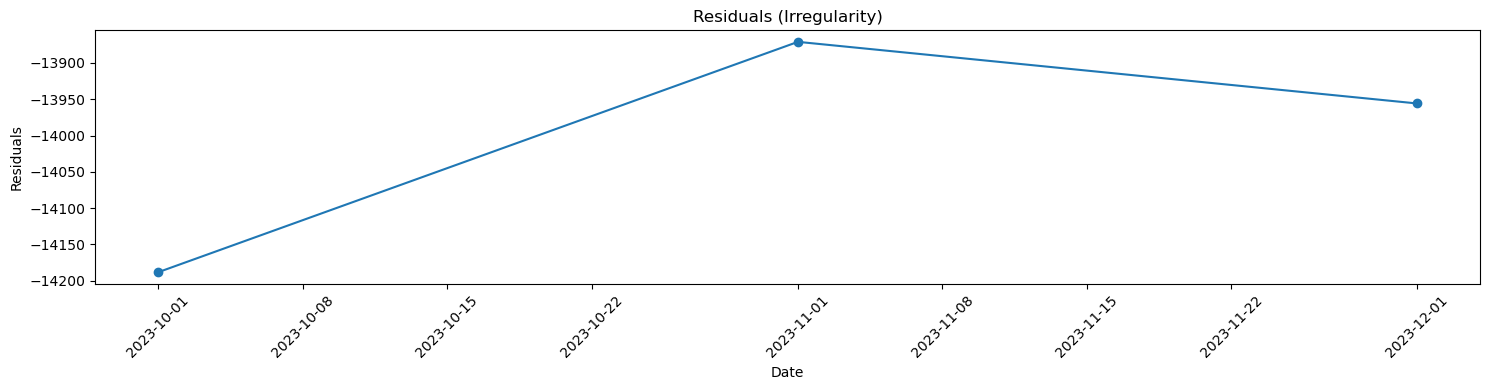

<Figure size 800x400 with 0 Axes>

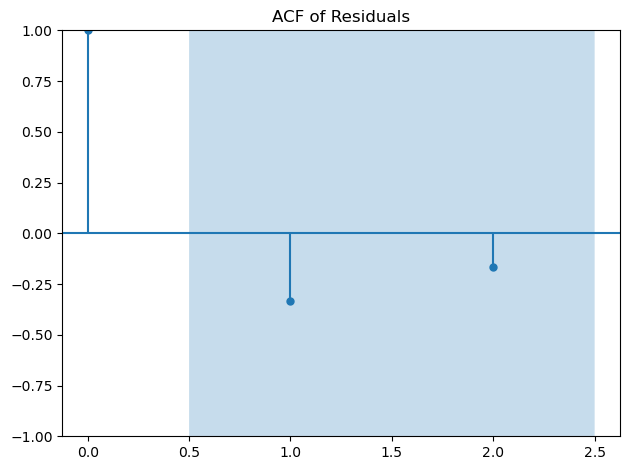

    lb_stat  lb_pvalue
2  1.250003   0.535261


In [86]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Load data
df = pd.read_csv('retailstore_inventory.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)

# Resample to monthly 'Units Sold'
test = df['Units Sold'].resample('MS').sum()
actual = test[-3:].values

# Forecasts (replace with your actual forecasts)
hw = test[-3:] * 1.1  # Holt-Winters placeholder
s = test[-3:] * 1.05  # SARIMA placeholder
p = test[-3:] * 0.95  # Prophet placeholder
# Example: hw = hw_forecast.loc[test[-3:].index].values

# Weighted average ensemble
final_pred = pd.Series((hw + s + p) / 3, index=test[-3:].index)

# Calculate residuals
residuals = actual - final_pred.values

# Plot residuals
plt.figure(figsize=(15, 4))
plt.plot(test[-3:].index, residuals, 'o-')
plt.title('Residuals (Irregularity)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ACF plot
plt.figure(figsize=(8, 4))
plot_acf(residuals, lags=min(20, len(residuals)-1))
plt.title('ACF of Residuals')
plt.tight_layout()
plt.show()

# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[len(residuals)-1], return_df=True)
print(lb_test)

In [87]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv('retailstore_inventory.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)

# Resample to monthly 'Units Sold'
test = df['Units Sold'].resample('MS').sum()
y_true = test[-3:].values

# Forecasts (replace with your actual forecasts)
hw = test[-3:] * 1.1
s = test[-3:] * 1.05
p = test[-3:] * 0.95
final_pred = (hw + s + p) / 3
y_pred = np.maximum(final_pred, 0)

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print results
print(f"Ensemble MAE: {mae:.2f}")
print(f"Ensemble RMSE: {rmse:.2f}")
print(f"Ensemble MAPE: {mape:.2f}%")
print(f"Mean monthly Units Sold: {test[-3:].mean():.2f}")


Ensemble MAE: 14004.93
Ensemble RMSE: 14005.58
Ensemble MAPE: 3.33%
Mean monthly Units Sold: 420148.00


In [82]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv('retailstore_inventory.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)

# Resample to monthly frequency
test = df['Units Sold'].resample('MS').sum()
y_true = test[-3:].values  # Last 3 months as test data

# Placeholder forecasts (replace with actual model forecasts)
hw = test[-3:] * 1.1
s = test[-3:] * 1.05
p = test[-3:] * 0.95

# Ensemble average
final_pred = (hw + s + p) / 3
y_pred = np.maximum(final_pred, 0)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print in scientific notation
print(f"MAE: {mae:.16e}")
print(f"RMSE: {rmse:.16e}")


MAE: 1.4004933333333349e+04
RMSE: 1.4005575725350205e+04
